## Import Packages

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, random, csv
import seaborn as sns
from glob import glob
from tqdm import tqdm
import multiprocessing
import math
%matplotlib inline

# MODEL METRICS
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# SET VARIABLES
PATH = '/home/pratik_sharma_ds/Capstone_Pneumonia_Detection/'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH + 'data/')
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + 'output/')
MODEL_WEIGHTS = os.path.join(PATH + 'model_weights/')
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR + 'stage_2_train_images_png/')
if not os.path.exists(TRAIN_IMAGES_DIR): os.makedirs(TRAIN_IMAGES_DIR)
if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

# CUSTOM MODULE
from module.classify import *

# SET RANDOM SEED
random_state = 2020
random.seed(random_state)
np.random.seed(random_state)

# USE GPU FOR MODEL TRAINING
config = tf.compat.v1.ConfigProto(log_device_placement = True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)

list_gpu = tf.config.experimental.list_physical_devices(device_type='GPU')
print('Num GPUs Available: ', len(list_gpu))

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Num GPUs Available:  1


## Read Data & Prep for Model
* Read a pickle file that was saved as part of [EDA & Data Prep](https://nbviewer.jupyter.org/github/sharmapratik88/Capstone_Pneumonia_Detection/blob/master/Pneumonia_Detection_EDA_%26_Data_Prep.ipynb)

In [3]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle(OUTPUT_DIR + 'train_class_features.pkl')
display(train_class.shape, train_class.head())

(30227, 12)

,patientId,x,y,width,height,Target,number_of_boxes,class,path,PatientSex,PatientAge,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,F,51.0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,F,48.0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,M,19.0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,M,28.0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/home/pratik_sharma_ds/Capstone_Pneumonia_Dete...,F,32.0,AP


In [4]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [5]:
# Run only if you haven't converted to png images yet
print('Convert dicom to png images'); print('--'*40)
# image_lists = [f for f in os.listdir(TRAIN_IMAGES)]
# for f in tqdm_notebook(image_lists): 
#     ds = dcm.read_file(TRAIN_IMAGES + f)
#     img = ds.pixel_array
#     cv2.imwrite(TRAIN_IMAGES_DIR + f.replace('.dcm','.png'), img)

Convert dicom to png images
--------------------------------------------------------------------------------


In [6]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_target['path'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


In [7]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class', 'patientId'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class', 'patientId'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class', 'patientId'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 2)
VALID:(2668, 2)
TEST:(2668, 2)


In [8]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

In [9]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle(OUTPUT_DIR + 'train_data.pkl')
df_valid.to_pickle(OUTPUT_DIR + 'valid_data.pkl')
df_test.to_pickle(OUTPUT_DIR + 'test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


## Model - DenseNet121

In [10]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
BETA1 = 0.9
BETA2 = 0.999
EP = 1e-08
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision]

In [11]:
print('Create a base `DenseNet121` model'); print('--'*40)
initializer = tf.keras.initializers.GlorotNormal()
base_model = DenseNet121(include_top = False, input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), weights = 'imagenet', pooling = 'avg')
x = base_model.output
output_layer = Dense(1, activation = 'sigmoid', kernel_initializer = initializer)(x)
model = Model(inputs = base_model.input, outputs = output_layer, name = 'DenseNet121')
model.summary()

Create a base `DenseNet121` model
--------------------------------------------------------------------------------
Model: "DenseNet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/c

In [12]:
# Learning Rate Scheduler
lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                patience = PATIENCE, verbose = VERBOSE, 
                                mode = MODE, cooldown = COOLDOWN)

# Adam optimizer
optimizer = Adam(lr = LEARNING_RATE, beta_1 = BETA1, beta_2 = BETA2, epsilon = EP)

# Compiler
model.compile(optimizer = optimizer, loss = LOSS, metrics = METRICS)

# Create a model checkpoint
cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                     verbose = VERBOSE, save_best_only = True, mode = MODE)

# Csv logger
if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)

# Tensorboard logs
logdir = MODEL_WEIGHTS; tb = TensorBoard(logdir, histogram_freq = 1)

# Callbacks
callbacks = [cp, csv_logger, lrscheduler, tb]

In [13]:
print('Lets fit the model.....')
train_generator = DataGenerator(dataset_df = df_train, img_dir = TRAIN_IMAGES_DIR,
                                batch_size = BATCH_SIZE, dim = (IMAGE_SIZE, IMAGE_SIZE),
                                transform = augmenter, n_channels = 3, shuffle = True)

validation_generator = DataGenerator(dataset_df = df_valid, img_dir = TRAIN_IMAGES_DIR,
                                     batch_size = BATCH_SIZE, dim = (IMAGE_SIZE, IMAGE_SIZE),
                                     transform = ImageDataGenerator(preprocessing_function = preprocess_input), 
                                     n_channels = 3, shuffle = True)

history = model.fit_generator(generator = train_generator,
                    steps_per_epoch = math.ceil((len(df_train) // BATCH_SIZE) + 1),
                    epochs = EPOCH,
                    verbose = VERBOSE,
                    callbacks = callbacks,
                    validation_data = validation_generator,
                    use_multiprocessing = True)

Lets fit the model.....
Train for 668 steps, validate for 83 steps
Epoch 1/10
667/668 [============================>.] - ETA: 0s - loss: 0.3959 - accuracy: 0.8207 - average_precision: 0.6437
Epoch 00001: val_loss improved from inf to 0.36612, saving model to /home/pratik_sharma_ds/Capstone_Pneumonia_Detection/model_weights/best_densenet.h5
668/668 [==============================] - 713s 1s/step - loss: 0.3962 - accuracy: 0.8205 - average_precision: 0.6437 - val_loss: 0.3661 - val_accuracy: 0.8392 - val_average_precision: 0.7178
Epoch 2/10
667/668 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.8353 - average_precision: 0.6875
Epoch 00002: val_loss did not improve from 0.36612
668/668 [==============================] - 692s 1s/step - loss: 0.3654 - accuracy: 0.8352 - average_precision: 0.6874 - val_loss: 0.3895 - val_accuracy: 0.8404 - val_average_precision: 0.7339
Epoch 3/10
667/668 [============================>.] - ETA: 0s - loss: 0.3519 - accuracy: 0.8436 - a

In [14]:
# %load_ext tensorboard
# %tensorboard --logdir log/

In [15]:
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

Save the final weights
--------------------------------------------------------------------------------


In [16]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [17]:
print('Evaluate the model on validation data'); print('--'*40)

validation_generator = DataGenerator(dataset_df = df_valid, img_dir = TRAIN_IMAGES_DIR,
                                     batch_size = BATCH_SIZE * 2, dim = (IMAGE_SIZE, IMAGE_SIZE),
                                     transform = ImageDataGenerator(preprocessing_function = preprocess_input), 
                                     n_channels = 3, shuffle = False)

loss, accuracy, ap = model.evaluate_generator(generator = validation_generator, 
                                              steps = math.ceil((len(df_valid) // BATCH_SIZE) + 1))
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}, AP: {round(float(ap), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.168, Accuracy: 0.851, AP: 0.773


In [18]:
print('Predict on the validation data'); print('--'*40)
y_valid, valid_pred, valid_pred_roc = predictor(model, validation_generator)

Predict on the validation data
--------------------------------------------------------------------------------


In [19]:
print('Predict on the test data'); print('--'*40)
test_generator = DataGenerator(dataset_df = df_test, img_dir = TRAIN_IMAGES_DIR,
                               batch_size = BATCH_SIZE * 2, dim = (IMAGE_SIZE, IMAGE_SIZE),
                               transform = ImageDataGenerator(preprocessing_function = preprocess_input), 
                               n_channels = 3, shuffle = False)

y_test, test_pred, test_pred_roc = predictor(model, test_generator)

Predict on the test data
--------------------------------------------------------------------------------


ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.878


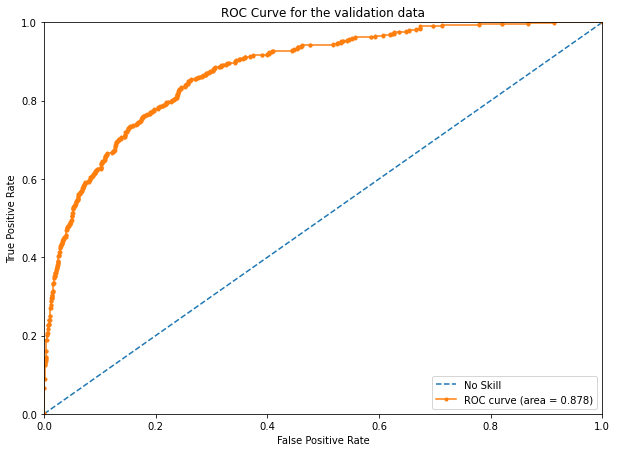

In [20]:
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.878


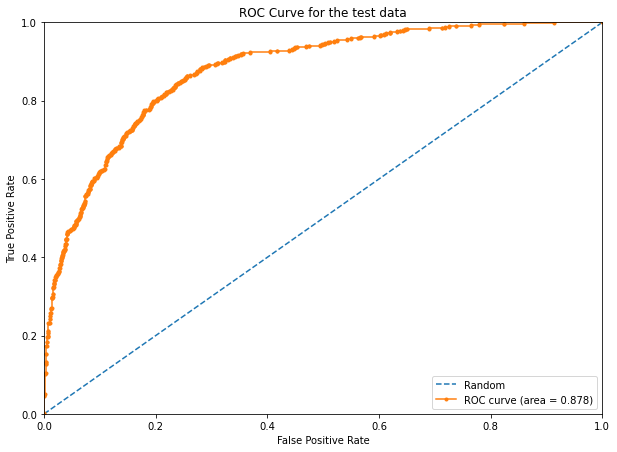

In [21]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


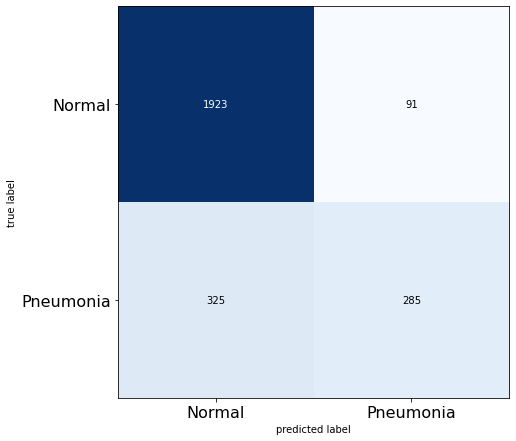

In [22]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [23]:
print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.86      0.95      0.90      2014
   Pneumonia       0.76      0.47      0.58       610

    accuracy                           0.84      2624
   macro avg       0.81      0.71      0.74      2624
weighted avg       0.83      0.84      0.83      2624



## Model - DenseNet121 + CheXNet pre-trained weights
Acknowledgement for the pre-trained weights:
We used pre-trained weights available from the following [repository](https://github.com/brucechou1983/CheXNet-Keras).

In [24]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-3
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
BETA1 = 0.9
BETA2 = 0.999
EP = 1e-08
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_chexnet.h5'
FINAL_MODEL = 'best_chexnet_final.h5'
LOG_FILE = 'logs_chexnet.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision]

In [25]:
print('Create a base `CheXNet-pretrained` model'); print('--'*40)

base_model = DenseNet121(include_top = True, input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), weights = MODEL_WEIGHTS + 'CheXNet weights.h5', pooling = 'avg', classes = 14)
x = base_model.output
output_layer = Dense(1, activation = 'sigmoid', kernel_initializer = initializer)(x)
model = Model(inputs = base_model.input, outputs = output_layer, name = 'CheXNet-pretrained')
model.summary()

Create a base `CheXNet-pretrained` model
--------------------------------------------------------------------------------
Model: "CheXNet-pretrained"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256  

In [26]:
# Learning Rate Scheduler
lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                patience = PATIENCE, verbose = VERBOSE, 
                                mode = MODE, cooldown = COOLDOWN)

# Adam optimizer
optimizer = Adam(lr = LEARNING_RATE, beta_1 = BETA1, beta_2 = BETA2, epsilon = EP)

# Compiler
model.compile(optimizer = optimizer, loss = LOSS, metrics = METRICS)

# Create a model checkpoint
cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                     verbose = VERBOSE, save_best_only = True, mode = MODE)

# Csv logger
if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)

# Tensorboard logs
logdir = MODEL_WEIGHTS; tb = TensorBoard(logdir, histogram_freq = 1)

# Callbacks
callbacks = [cp, csv_logger, lrscheduler, tb]

In [27]:
print('Lets fit the model.....')
train_generator = DataGenerator(dataset_df = df_train, img_dir = TRAIN_IMAGES_DIR,
                                batch_size = BATCH_SIZE, dim = (IMAGE_SIZE, IMAGE_SIZE),
                                transform = augmenter, n_channels = 3, shuffle = True)

validation_generator = DataGenerator(dataset_df = df_valid, img_dir = TRAIN_IMAGES_DIR,
                                     batch_size = BATCH_SIZE, dim = (IMAGE_SIZE, IMAGE_SIZE),
                                     transform = ImageDataGenerator(preprocessing_function = preprocess_input), 
                                     n_channels = 3, shuffle = True)

history = model.fit_generator(generator = train_generator,
                    steps_per_epoch = math.ceil((len(df_train) // BATCH_SIZE) + 1),
                    epochs = EPOCH,
                    verbose = VERBOSE,
                    callbacks = callbacks,
                    validation_data = validation_generator,
                    use_multiprocessing = True)

Lets fit the model.....
Train for 668 steps, validate for 83 steps
Epoch 1/10
667/668 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8182 - average_precision: 0.6027
Epoch 00001: val_loss improved from inf to 0.43320, saving model to /home/pratik_sharma_ds/Capstone_Pneumonia_Detection/model_weights/best_chexnet.h5
668/668 [==============================] - 712s 1s/step - loss: 0.4855 - accuracy: 0.8183 - average_precision: 0.6028 - val_loss: 0.4332 - val_accuracy: 0.8309 - val_average_precision: 0.6432
Epoch 2/10
667/668 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.8279 - average_precision: 0.6418
Epoch 00002: val_loss improved from 0.43320 to 0.41987, saving model to /home/pratik_sharma_ds/Capstone_Pneumonia_Detection/model_weights/best_chexnet.h5
668/668 [==============================] - 704s 1s/step - loss: 0.4206 - accuracy: 0.8278 - average_precision: 0.6414 - val_loss: 0.4199 - val_accuracy: 0.8001 - val_average_precision: 0.54

In [28]:
# %load_ext tensorboard
# %tensorboard --logdir log/

In [29]:
print('Save the final weights'); print('--'*40)
model.save(MODEL_WEIGHTS + FINAL_MODEL)

Save the final weights
--------------------------------------------------------------------------------


In [30]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [31]:
print('Evaluate the model on validation data'); print('--'*40)

validation_generator = DataGenerator(dataset_df = df_valid, img_dir = TRAIN_IMAGES_DIR,
                                     batch_size = BATCH_SIZE * 2, dim = (IMAGE_SIZE, IMAGE_SIZE),
                                     transform = ImageDataGenerator(preprocessing_function = preprocess_input), 
                                     n_channels = 3, shuffle = False)

loss, accuracy, ap = model.evaluate_generator(generator = validation_generator, 
                                              steps = math.ceil((len(df_valid) // BATCH_SIZE) + 1))
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}, AP: {round(float(ap), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.168, Accuracy: 0.852, AP: 0.734


In [32]:
print('Predict on the validation data'); print('--'*40)
y_valid, valid_pred, valid_pred_roc = predictor(model, validation_generator)

Predict on the validation data
--------------------------------------------------------------------------------


In [33]:
print('Predict on the test data'); print('--'*40)
test_generator = DataGenerator(dataset_df = df_test, img_dir = TRAIN_IMAGES_DIR,
                               batch_size = BATCH_SIZE * 2, dim = (IMAGE_SIZE, IMAGE_SIZE),
                               transform = ImageDataGenerator(preprocessing_function = preprocess_input), 
                               n_channels = 3, shuffle = False)

y_test, test_pred, test_pred_roc = predictor(model, test_generator)

Predict on the test data
--------------------------------------------------------------------------------


ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.885


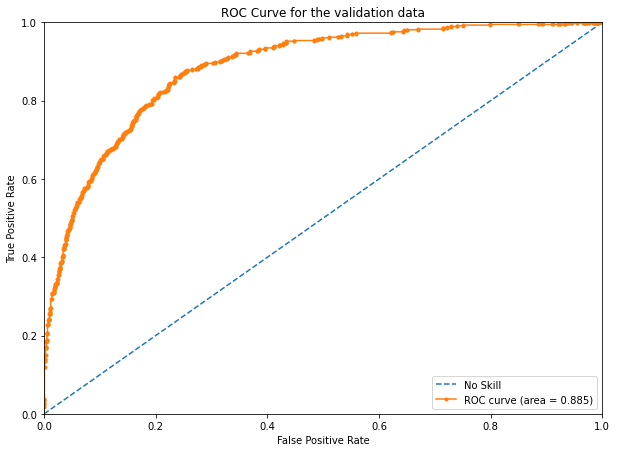

In [34]:
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.890


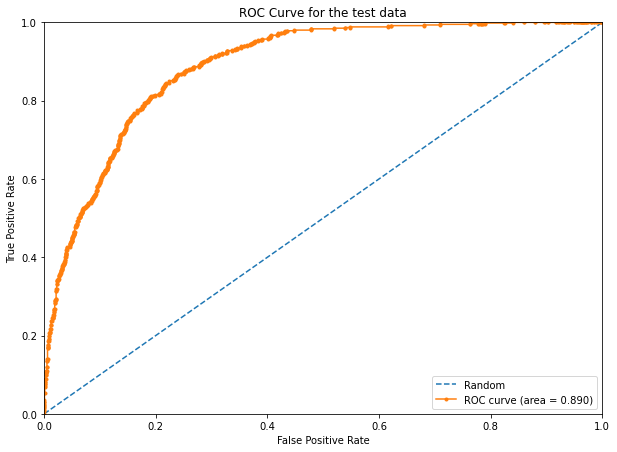

In [35]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


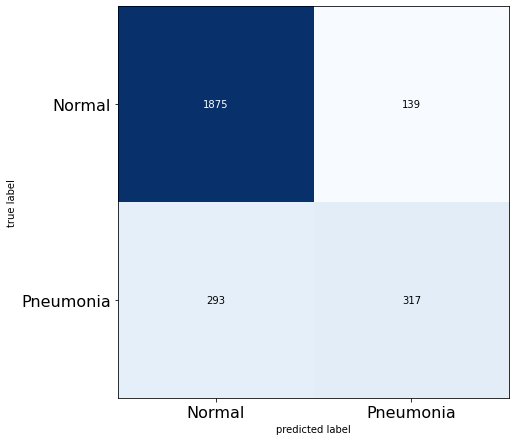

In [36]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [37]:
print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.86      0.93      0.90      2014
   Pneumonia       0.70      0.52      0.59       610

    accuracy                           0.84      2624
   macro avg       0.78      0.73      0.75      2624
weighted avg       0.83      0.84      0.83      2624

